## <center>Visual Concept Detection Task</center>

### Group:
 - Nooshin Shojaee
 - Francesco Ciraolo
 - Lucas Souza Romao
     - Student#: 0190727830

### Introduction

As part of the evaluation of the semester a challenge was given based on ImageCLEF 2008: Visual Concept Detection Task [[1]](#1).
This challenge utilizes the IAPR TC-12 dataset that contains a split in the train set with x images and a test set with x images. Each of these images can have more than one classification associated with it. As it is a multi-classification problem the decision was to utilize a convolutional neural network (CNN), for better accuracy we decide to move forward in the utilization of EfficientNet as the main model, it provides us better results than ResNet50.
In the next sections, we will be giving a walkthrough of the code.

### Enviroments Setup

As the frameworks we will be mainly utilizing Keras that runs on top the Tensorflow [[2]](#2) plataform, also to support the plot of the images matplot and seaborn are being used.

In [10]:
import pandas as pd
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers

from PIL import Image
import imghdr

import matplotlib.pyplot as plt
import matplotlib.style as style

import seaborn as sns

from sklearn.model_selection import train_test_split

### Understading the data

In [9]:
train_pics_dir = './train/train/'
test_pics_dir = './test/test/'
#test_pics_dir = '/home/lucas/Documents/ML_FinalProject/test/test/'

In [12]:
test_df = pd.read_csv('test/test.anno.txt', sep=" ")
labels = test_df.columns
file_names = test_df['file_name']
#test_df['file_name'] = test_df['file_name'].apply(lambda x: os.path.join(test_pics_dir, x))
#test_df['classes'] = test_df.loc[:, (test_df.columns != 'file_name')].values.tolist()
test_df.head()

,file_name,indoor,outdoor,person,day,night,water,road,vegetation,tree,mountains,beach,buildings,sky,sunny,partly_cloudy,overcast,animal
0,27-27707.jpg,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1
1,27-27708.jpg,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,27-27711.jpg,0,1,1,0,0,0,1,1,1,1,0,0,1,0,0,1,0
3,27-27713.jpg,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
4,27-27715.jpg,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0


In [306]:
train_df = pd.read_csv('train/train.anno.txt', sep=" ", names=labels)
#train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(train_pics_dir, x))
train_df['classes'] = add_labels_dataframe(train_df)
#train_df['classes'] = train_df.loc[:, (train_df.columns != 'file_name')].values.tolist()
train_df.head()
#columns = train_df.columns[0:18].tolist()

,file_name,indoor,outdoor,person,day,night,water,road,vegetation,tree,mountains,beach,buildings,sky,sunny,partly_cloudy,overcast,animal,classes
0,27-27700.jpg,0,1,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,"[outdoor, night, vegetation, tree, mountains, ..."
1,27-27704.jpg,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,"[outdoor, day, mountains, sky, partly_cloudy]"
2,27-27705.jpg,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,"[outdoor, night, vegetation, mountains, sky, o..."
3,27-27706.jpg,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[indoor]
4,27-27709.jpg,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,"[outdoor, day, road, sky, overcast]"


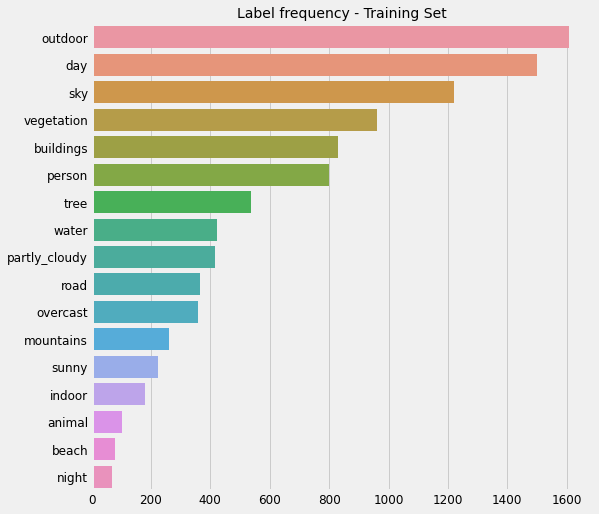

In [30]:
labels_freq = []

for column in train_df:
    if train_df[column].name != 'file_name' and train_df[column].name != 'classes':
        labels_freq.append(
            [train_df[column].name, 
            train_df[column].value_counts()[1]
            ])
    df_labels_freq = pd.DataFrame(labels_freq, columns = ['Label', 'Count']).sort_values(by=['Count'], ascending=False)

style.use("fivethirtyeight")
plt.figure(figsize=(8,8))
sns.barplot(y=df_labels_freq.Label, x=df_labels_freq.Count)
plt.title("Label frequency - Training Set", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

As it can be noticed in the plot above, our train set is imbalance, it will be a problem for our model because the difference between the majority classes such as outdoor, day and sky and the minority classes such as night, beach and animal, to overcome this problem we tried to use techniques to oversampling the minority ones and under sampling the majority. For it utilized SMOTETomek that is a combination of over and under sampling using SMOTE and Tomek links.[[3]](#3)
However the results after gave us a train set with more than 8 thousand obersavations as it can been seeing below:

<img src="over.png">

Notice that the classes are more well balanced but still not in the ideal, to have a better view about this effect of a big enlarge in our training set we can see the correlation plot.

<AxesSubplot:>

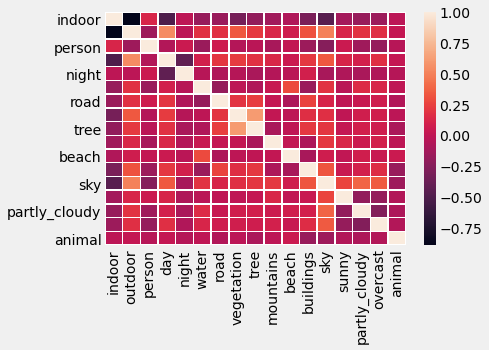

In [31]:
sns.heatmap(train_df.corr(), linewidths=.5)

As we can see the labels are quite well correlated so the under and oversampling doesn't help in our problem as always we can be increasing a majority class by doing oversampling of a minory one, to overcome it the class weights will be calculate in order to give those wieghts as parameters in the model, it will kind say to our model during the training to pay more attention in the labeling.

### Data Preprocessing

In this section the data will be handle in order to utilize it to train the model, for it we decide to utilize ImageDataGenerator provided by Tensorflow, generator are a easy way to handle data since it is possible to add data argumentation on it and generate the images for the model.
For the input size of the image since EfficientNetB2 was choose, it requires an image size of 224x224. The channel will be the same RGB. 
For the batch size the best results were with the size of 32. But also tried with 16, 64 and 120.

In [50]:
def add_labels_dataframe(dataset):
    
    df = dataset.copy()
    
    for column in df.loc[:, df.columns != 'file_name']:
        df[column]= df[column].replace(1,df[column].name)
    
    df['classes'] = df.loc[:, (df.columns != 'file_name')].values.tolist()
    df['classes']= df['classes'].apply(lambda x : list(filter(lambda b: b != 0, x)))
    
    return df['classes']

In [34]:
CHANNELS = 3
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 2 


In [35]:
class_weights = {}
weights =list()

In [229]:
index = 0
train_size = len(train_df)

for column in train_df:
    if train_df[column].name != 'file_name' and train_df[column].name != 'classes':
        class_weights[index] = len(train_df[train_df[column] == 1]) / train_size
        weights.append(len(train_df[train_df[column] == 1]) / train_size)
        index += 1

In [307]:
train_df, val_df = train_test_split(train_df, test_size=0.1)

train = ImageDataGenerator(rescale=1./255,
                               rotation_range=45,
                               shear_range=0.2,
                               zoom_range=0.4,
                               horizontal_flip=True,
                               vertical_flip=True)

val = ImageDataGenerator(rescale=1./255)


train_data_gen = train.flow_from_dataframe(dataframe=train_df,
                                               batch_size=BATCH_SIZE,
                                               directory=train_pics_dir,
                                               x_col='file_name',
                                               y_col=train_df.columns[1:18].tolist(),
                                               shuffle=True, seed=42,
                                               classes=labels[1:].tolist(),
                                           class_mode='raw',
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

val_data_gen = val.flow_from_dataframe(dataframe=val_df,
                                             batch_size=BATCH_SIZE,
                                             directory=train_pics_dir,
                                             x_col='file_name',
                                             y_col=train_df.columns[1:18].tolist(),
                                             shuffle=False, seed=42,
                                             class_mode='raw',
                                             classes=labels[1:].tolist(),
                                       target_size=(IMG_HEIGHT, IMG_WIDTH))


test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=test_pics_dir,
                                                x_col='file_name',
                                                y_col=None,
                                                batch_size=1,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1644 validated image filenames.
Found 183 validated image filenames.
Found 1000 validated image filenames.


/home/lucas/.local/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:219: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn('`classes` will be ignored given the class_mode="{}"'


[0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0]


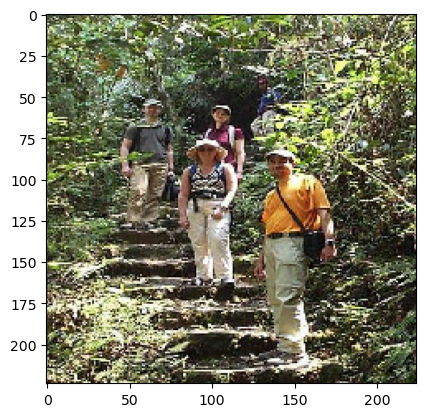

In [345]:
for i, l in val_data_gen:
    plt. imshow(i[1])
    print(l[1])
    break

### Model 

- Very simple one, needs to improve

In [39]:
from tensorflow.keras.applications import EfficientNetB2, MobileNetV2, ResNet50

In [40]:
effic_b2 = EfficientNetB2(weights=None, include_top=False, drop_connect_rate=0.2, pooling='avg', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))


In [ ]:
v2 = MobileNetV2(weights='imagenet', include_top=False,classes=17, pooling='avg', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))


In [ ]:
res50 = ResNet50(weights=None ,pooling='avg', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))

In [42]:
model = Sequential()
model.add(effic_b2)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(17, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense (Dense)                (None, 512)               721408    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                8721      
Total params: 8,498,698
Trainable params: 8,431,123
Non-trainable params: 67,575
_________________________________________________________________


In [43]:
#opt = optimizers.SGD(lr=1e-5, momentum=0.9)
#model.compile(optimizers.Adam(lr=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])
#model.compile(optimizer=opt,loss = 'categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizers.Adam(lr=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',loss="binary_crossentropy",metrics=["accuracy"])

In [47]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=3, 
                        verbose=1,
                        mode='auto', 
                        min_delta=0.0001)

For a faster training is suggest to utilize HPC facilities.TODO: add HPC ref

In [46]:
with tf.device('/gpu:0'):
    model_trained = model.fit(
        train_data_gen,
        steps_per_epoch=train_data_gen.n//train_data_gen.batch_size,
        epochs = 2,
        callbacks=[reduce_lr],
        validation_data=val_data_gen,
        validation_steps=val_data_gen.n//val_data_gen.batch_size,
        class_weight=class_weights
    )

Epoch 1/2
822/822 [==============================] - 232s 273ms/step - loss: 0.3830 - accuracy: 0.7968 - val_loss: 5.1597 - val_accuracy: 0.8681
Epoch 2/2
822/822 [==============================] - 241s 293ms/step - loss: 0.3574 - accuracy: 0.8930 - val_loss: 0.5201 - val_accuracy: 0.8681


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = model_trained.history['loss']
val_loss = model_trained.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig

In [ ]:
test_generator.reset()
np.set_printoptions(precision=2)
yhat = model_trained.model.predict(test_generator)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score

out = []
test_classes = np.array(list(test_df.classes.values))





# thresholds = np.arange(0, 1, 0.001)

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# yhat = yhat[:, 1]
#fpr, tpr, thresholds = roc_curve(test_classes[0], yhat[0][:, 1])
# idx_test = 0
# for i in range(len(yhat)):
#     fpr, tpr, thresholds = roc_curve(test_classes[i], yhat[i])
#     J = tpr - fpr
#     ix = tf.argmax(J)
#     out.append(to_labels(yhat[i], thresholds[ix]))

# scores = [f1_score(test_classes, to_labels(yhat, t), average='micro') for t in thresholds]

# idx_scores= 0
# for i in scores:
#     out.append(to_labels(yhat[idx_scores], i))
#     idx_scores += 1

# s= f1_score([[0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0],
#             [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]], 
#             [[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0],
#             [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]], average='micro') 
#precision, recall, thresholds = precision_recall_curve(test_classes[0], yhat[0])
# thresholds

# fscore = (2 * precision * recall) / (precision + recall)
# ix = tf.argmax(fscore)
# print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# thresholds
df_tt = pd.DataFrame(data=yhat, columns=labels[1:].to_list())

df_tt.indoor.values[0]
precision, recall, thresholds = precision_recall_curve(test_df.indoor.values, df_tt.indoor.values)

fscore = (2 * precision * recall) / (precision + recall)

ix = tf.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

In [ ]:
model = tf.keras.models.load_model('test/model_b2_avg.h5')

In [ ]:
test = list(test_df['classes'].values)
test = np.array(test)

In [ ]:
test_generator.reset()

yhat = model.predict(test_generator)


In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(17):
    fpr[i], tpr[i], _ = roc_curve(test[:, i], yhat[:, i])
    print( tpr[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
df_tt = pd.DataFrame(data=yhat, columns=labels[1:].to_list())

In [ ]:
thresholds_dict = {}

for i in labels[1:]:
    precision, recall, thresholds = precision_recall_curve(test_df[i].values, df_tt[i].values)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = tf.argmax(fscore)
    thresholds_dict[i] = thresholds[ix]

In [ ]:
for i in thresholds_dict:
    df_tt[i] = df_tt[i].map(lambda x: 1 if x > thresholds_dict[i] else 0)

In [ ]:
df_tt['file_name'] = test_df['file_name']

df_tt.to_csv('./test/test.eval_b2_1.txt', index=None, sep=' ')

In [ ]:
yhat = (yhat > 0.5).astype("int32")


In [ ]:
df_out = pd.DataFrame(data=out, columns=labels[1:].to_list())
df_out['file_name'] = test_df['file_name']

In [ ]:
test_classes[0]

In [ ]:
df_out.to_csv('./test/test.eval.txt', index=None, sep=' ')

In [ ]:
import tensorflow_addons as tfa

In [ ]:
import math
def create_class_weight(labels_dict,mu=0.15):
    total = sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        value = float(labels_dict[key])
        score = math.log(mu*total/value)
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

In [ ]:
class_weights = {}

index = 0
train_size = len(train_df)

for column in train_df:
    if train_df[column].name != 'file_name' and train_df[column].name != 'classes':
        class_weights[index] = len(train_df[train_df[column] == 1])
        index += 1

In [ ]:
create_class_weight(class_weights)

In [ ]:
plot()

In [ ]:
0.25 * class_weights[0]

In [ ]:
thresholds = np.arange(0, 1, 0.001)

thresholds_dict2 = {}
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

for i in labels[1:]:
    scores = [f1_score(test_df[i].values, to_labels(df_tt[i].values, t)) for t in thresholds]

    ix = tf.argmax(scores)
    thresholds_dict2[i] = thresholds[ix]

In [ ]:
thresholds_dict2

In [ ]:
for i in thresholds_dict2:
    df_tt[i] = df_tt[i].map(lambda x: 1 if x > thresholds_dict2[i] else 0)
    
df_tt['file_name'] = test_df['file_name']

df_tt.to_csv('./test/test.eval_b2_1.txt', index=None, sep=' ')

In [ ]:
thresholds_dict3 = {}

for i in labels[1:]:
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(test_df[i].values, df_tt[i].values)
    # get the best threshold
    J = tpr - fpr
    ix = tf.argmax(J)
    best_thresh = thresholds[ix]
    thresholds_dict3[i] = best_thresh
    


In [ ]:
thresholds_dict3

In [ ]:
for i in thresholds_dict3:
    df_tt[i] = df_tt[i].map(lambda x: 1 if x > thresholds_dict3[i] else 0)
    
df_tt['file_name'] = test_df['file_name']

df_tt.to_csv('./test/test.eval_b2_1.txt', index=None, sep=' ')

In [48]:
len(train_df[train_df['indoor'] == 1]) / train_size

0.08702791461412152

### References

<a id='1'>[1]</a>   ImageCLEF. <i>ImageCLEF 2008: Visual Concept Detection Task.</i> URL:https://www.imageclef.org/2008/vcdt.

<a id='2'>[2]</a>   Tensorflow. <i>Tensorflow.</i> URL:https://www.tensorflow.org/about

<a id='3'>[3]</a>   SMOTETomek. <i>imbalanced-learn.</i> URL:https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html